In [1]:
import os
import pandas as pd

In [2]:
import re
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.tokens import Span
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
with open('/content/data.txt', 'r', errors='replace') as f:
    lines = f.readlines()
texts=lines[0]

In [4]:
with open ("/content/df_1000.csv", "r", encoding="utf-8") as myfile:
    text1=myfile.readlines()

In [5]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""
    prv_tok_dep = ""
    prv_tok_text = ""
    prefix = ""
    modifier = ""
    for tok in nlp(sent):
        if tok.dep_ != "punct":
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    return [ent1.strip(), ent2.strip()]

In [6]:
text1

['cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id\n',
 'ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,"Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia",10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,"OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups bu

In [7]:
get_entities(texts)

['', '']

In [8]:
entity_pairs = []

for i in tqdm(text1):
    entity_pairs.append(get_entities(i))

100%|██████████| 10001/10001 [09:42<00:00, 17.17it/s]


In [9]:
entity_pairs[10:20]

[['Association,,,,document_parses pmc_json PMC212776.xml.json',
  '09 American Medical Informatics'],
 ['John F.",EMBO J,,,,document_parses', 'common  yeast'],
 ['PMC302072.xml.json', 'dependent RNA synthesis'],
 ['pmc  PMC302190/', 'important  roles'],
 ['articles  render', 'viral centrosome function'],
 ['pmc_json  PMC420498.xml.json', '",2004  05'],
 ['pmc_json Rob JM PMC468896.xml.json', 'primary  lungs'],
 ['pmc_json Tomás PMC520756.xml.json', 'public  08'],
 ['09 Ted Rinne', 'damaging excision repair O(2'],
 ['pmc_json  PMC544882.xml.json', 'viral RNA environment']]

In [10]:
def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

    matcher.add("matching_1", [pattern])
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]]
    return(span.text)

In [ ]:
get_relation(texts)

['', '']

In [11]:
relations = [get_relation(i) for i in tqdm(text1)]

100%|██████████| 10001/10001 [09:06<00:00, 18.32it/s]


In [12]:
pd.Series(relations).value_counts()[:50]

document_parses            5587
articles                    112
",2016                      111
",2002                      105
",2006                       57
",2009                       52
",2019                       48
",2017                       39
",2012                       34
",2005                       34
",2018                       32
",2015                       31
",2011                       28
",2008                       25
Sci,,,,document_parses       23
",2020                       20
suggest                      20
",2013                       19
",1992                       17
",2000                       17
",1998                       14
K.                           13
",2003                       12
indicate                     12
Dis,,,,document_parses       11
A.                           11
E.                           11
C.                           10
J.                           10
Res,,,,document_parses       10
M.                            9
Med,,,,d

In [13]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.to_csv('Knowledge_Graph_df.csv', index = False)
kg_df

,source,target,edge
0,,,cord_uid
1,07 Al Ghamdi,"Infect Dis,,,,document_parses",""",2001"
2,"pmc_json Carroll E"",Respir PMC59543.xml.json",inflammatory lung,document_parses
3,"human Erika C"",Respir Res,,,,document_parses",human lung diseases,""",2000"
4,pmc_json David PMC59574.xml.json,lung disease,document_parses
...,...,...,...
9996,"02 drug 17,""Casili",novel drug migraine,document_parses
9997,pmc_json Health Prev PMC7469908.xml.json,induced neurotoxicity,document_parses
9998,"pmc_json Andreas"",Eur Respir PMC7469974.xml.json",devastating outcome,document_parses
9999,"pmc_json B."",Epidemiol PMC7471572.xml.json",effective control measures,document_parses


In [14]:
kg_df['edge'].value_counts()

document_parses        5587
articles                112
",2016                  111
",2002                  105
",2006                   57
                       ... 
PMC7079901/               1
",2004,"Alpers            1
contain                   1
PMC7079920/               1
PMC7472590.xml.json       1
Name: edge, Length: 3169, dtype: int64

In [26]:
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1


  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3


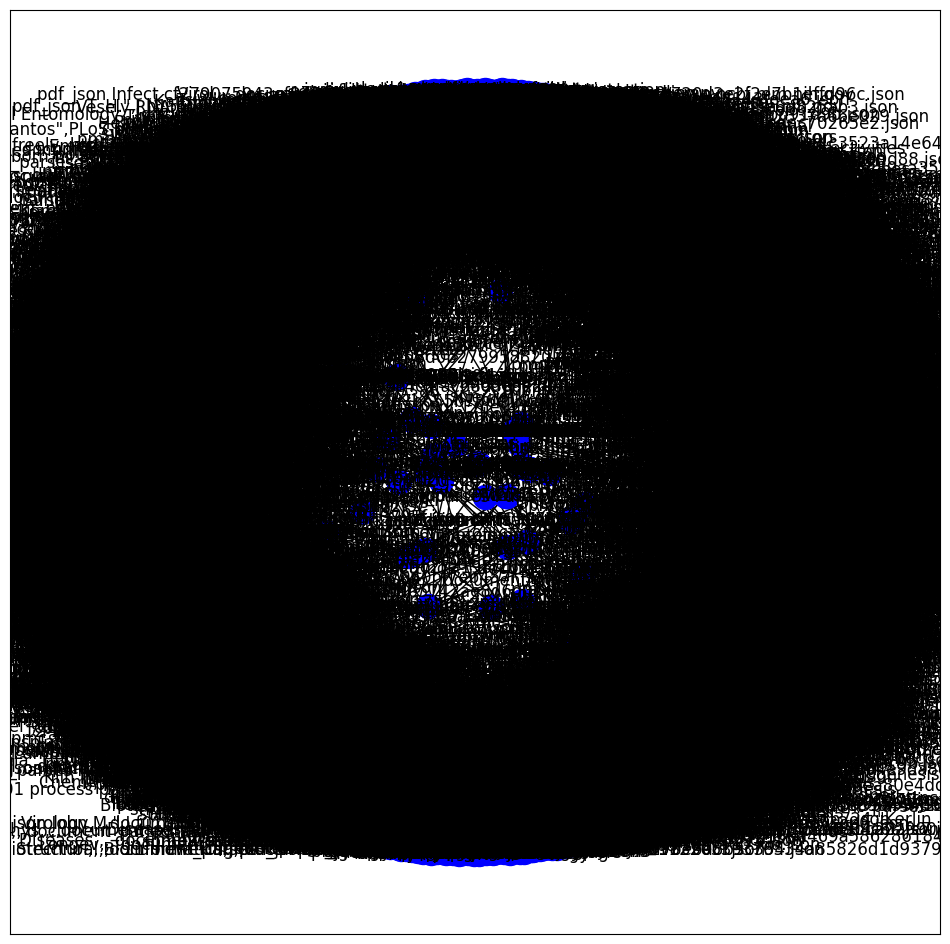

In [27]:
plt.figure(figsize=(12,12))

!pip install 'networkx<2.7'
!pip install 'scipy>=1.8'
!pip install --upgrade scipy networkx
pos = nx.spring_layout(G)
nx.draw_networkx(G, with_labels=True, node_color='blue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

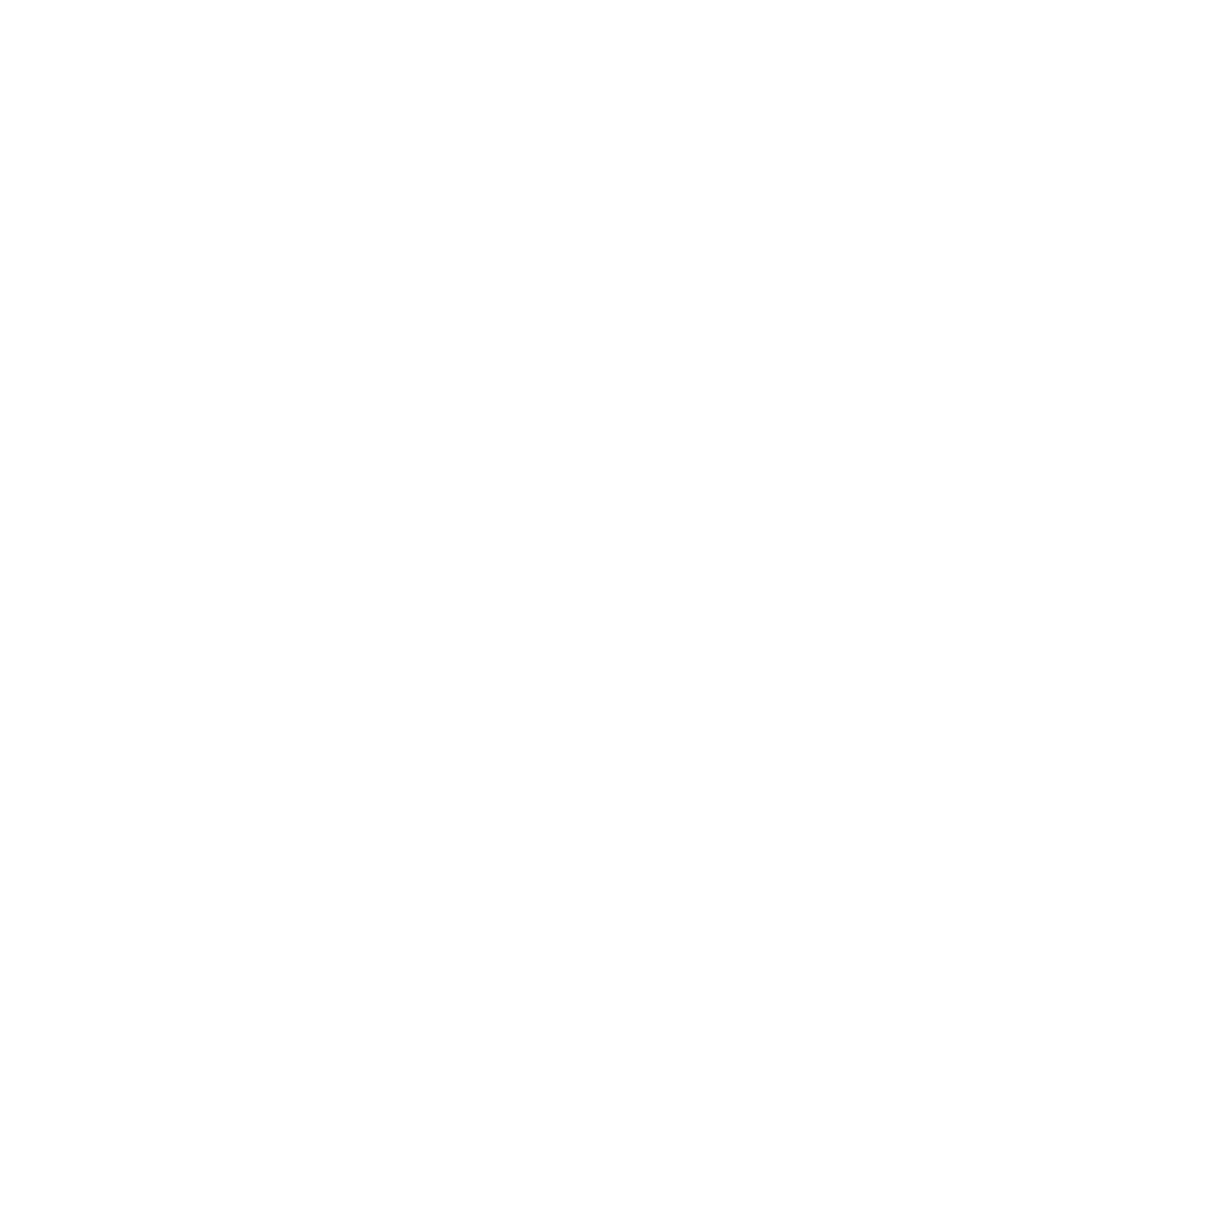

In [28]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="CONCLUSIONS"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='green', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

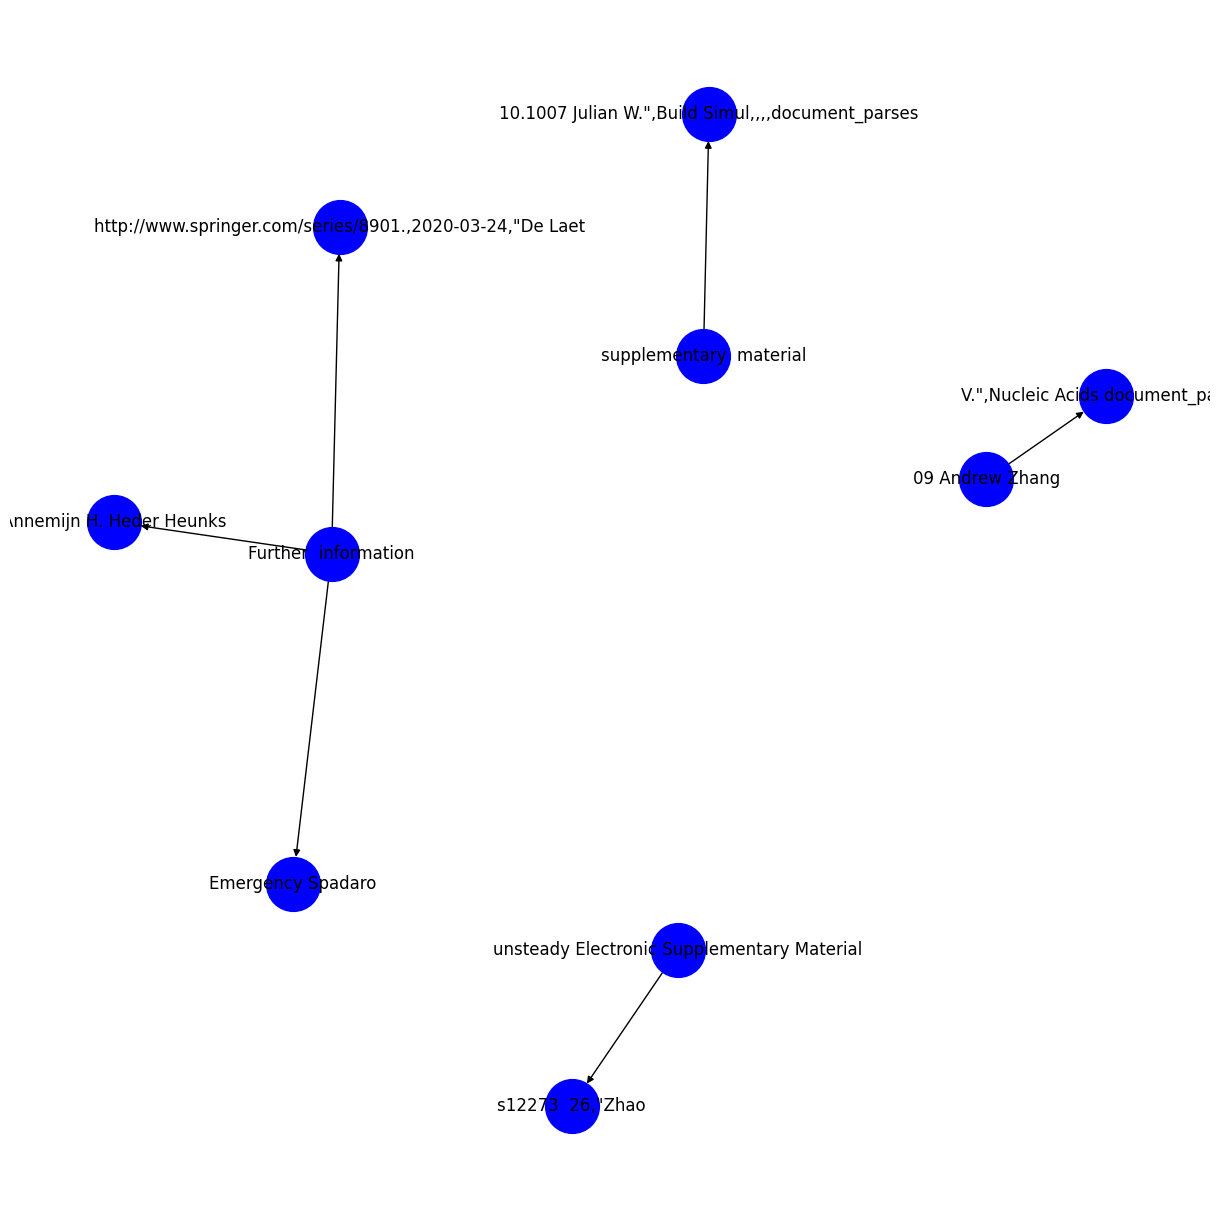

In [29]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is available"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='blue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

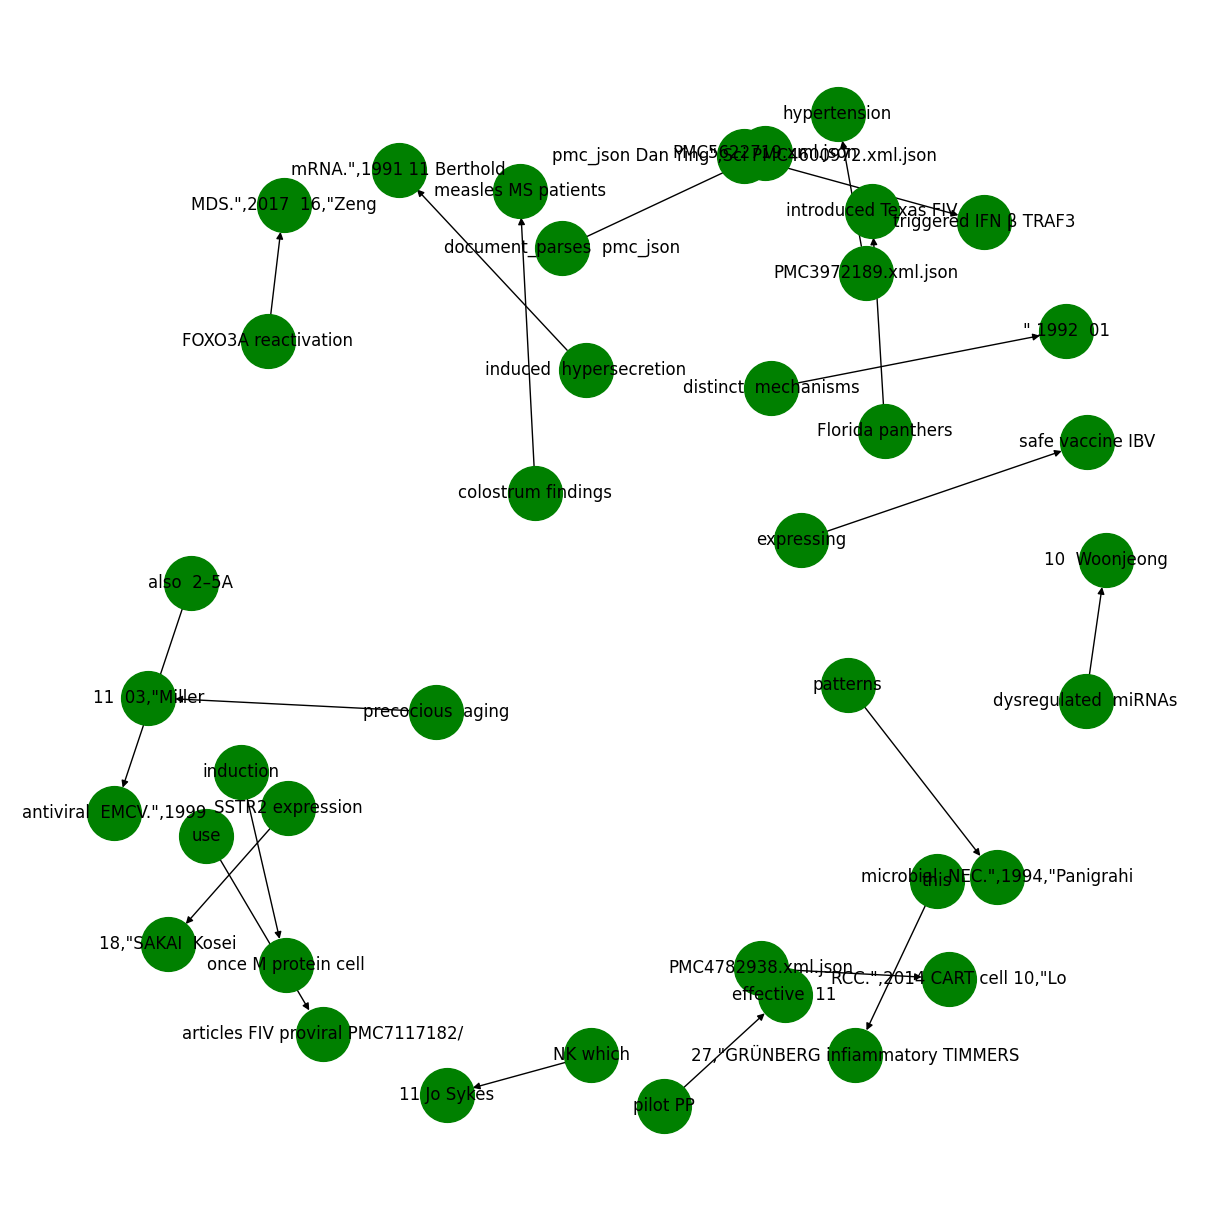

In [30]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="suggest"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='green', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()